# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [30]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2023-10-27'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

# Get IQ data

In [62]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.1

IQ_data = simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
# IQ_data_extreme = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_list=NOISE_LIST)

# Decode using predecoder

In [63]:
import pymatching
import stim
from src import cpp_soft_info
import numpy as np

model = simulator.stim_circ.detector_error_model(decompose_errors=False)
matching = pymatching.Matching.from_detector_error_model(model)

In [64]:
_DETAILED = True

result_predecoder = cpp_soft_info.decode_time_nn_predecode_grid(model, IQ_data, ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED, threshold=0.2, _ntnn_edges = not _RESETS)


print(f"num_errors: {result_predecoder.decode_result.num_errors}")
print(f"mean num removed edges: {np.mean(result_predecoder.nb_rm_edges)}")
print(f"num removed edges: {np.sum(result_predecoder.nb_rm_edges)}")

num_errors: 167
mean num removed edges: 0.0667
num removed edges: 667


In [65]:
for threshold in np.linspace(0, 0.4, 20):
    result_predecoder_loop = cpp_soft_info.decode_time_nn_predecode_grid(model, IQ_data[:], ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                               simulator.processed_scaler_dict, _detailed=_DETAILED, threshold=threshold, _ntnn_edges = not _RESETS)
    print(f"threshold: {threshold}, num_errors: {result_predecoder_loop.decode_result.num_errors}, mean num removed edges: {np.mean(result_predecoder_loop.nb_rm_edges)}, num removed edges: {np.sum(result_predecoder_loop.nb_rm_edges)}")

threshold: 0.0, num_errors: 452, mean num removed edges: 1.0419, num removed edges: 10419
threshold: 0.021052631578947368, num_errors: 175, mean num removed edges: 0.186, num removed edges: 1860
threshold: 0.042105263157894736, num_errors: 170, mean num removed edges: 0.1232, num removed edges: 1232
threshold: 0.06315789473684211, num_errors: 169, mean num removed edges: 0.1074, num removed edges: 1074
threshold: 0.08421052631578947, num_errors: 169, mean num removed edges: 0.0972, num removed edges: 972
threshold: 0.10526315789473684, num_errors: 168, mean num removed edges: 0.089, num removed edges: 890
threshold: 0.12631578947368421, num_errors: 168, mean num removed edges: 0.083, num removed edges: 830
threshold: 0.14736842105263157, num_errors: 168, mean num removed edges: 0.0785, num removed edges: 785
threshold: 0.16842105263157894, num_errors: 167, mean num removed edges: 0.0732, num removed edges: 732
threshold: 0.18947368421052632, num_errors: 167, mean num removed edges: 0.0

In [66]:
# Soft Grid info

result = cpp_soft_info.decode_IQ_fast(model, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED, nb_intervals=-1)

print(f"num_errors: {result.num_errors}")

num_errors: 126


In [67]:
# Hard decoder
p_meas = 0.02
p_meas = -1

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(model, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = not _RESETS)

print(f"num_errors: {result_informed.num_errors}")

num_errors: 169


# Analyse shots

In [68]:
print("Predecoder result:")
print(sorted(set(result_predecoder.decode_result.indices)))
print("Informed result:")
print(sorted(set(result_informed.indices)))
print("Soft result:")
print(sorted(set(result.indices)))


Predecoder result:
[42, 65, 66, 458, 751, 768, 901, 934, 948, 1029, 1046, 1049, 1076, 1165, 1195, 1335, 1425, 1471, 1578, 1588, 1671, 1718, 1807, 1897, 1954, 2115, 2212, 2305, 2342, 2411, 2432, 2589, 2591, 2640, 2677, 2729, 2850, 2869, 2901, 3015, 3137, 3154, 3161, 3183, 3246, 3253, 3316, 3340, 3431, 3440, 3467, 3516, 3746, 3844, 3863, 3886, 3896, 3960, 4065, 4173, 4268, 4393, 4461, 4507, 4549, 4592, 4621, 4674, 4686, 4715, 4717, 4730, 4749, 4935, 5016, 5052, 5176, 5189, 5265, 5332, 5364, 5365, 5386, 5425, 5589, 5630, 5723, 5789, 5848, 5854, 5938, 6095, 6104, 6155, 6180, 6222, 6234, 6240, 6320, 6459, 6470, 6526, 6548, 6576, 6587, 6620, 6699, 6763, 6774, 6796, 6899, 6914, 6953, 6957, 6958, 6959, 7016, 7157, 7181, 7193, 7215, 7233, 7327, 7349, 7354, 7371, 7378, 7453, 7528, 7614, 7657, 7710, 7939, 8035, 8225, 8247, 8326, 8502, 8599, 8651, 8677, 8777, 8841, 8954, 8987, 8992, 9137, 9142, 9156, 9250, 9357, 9378, 9523, 9533, 9599, 9634, 9647, 9662, 9693, 9773, 9814, 9828, 9850, 9863, 9879, 98

In [69]:
threshold_not_in_informed = sorted(set(result_predecoder.decode_result.indices)-set(result_informed.indices))
print("Indices that are in threshold but not in informed:", threshold_not_in_informed)

informed_not_in_threshold = sorted(set(result_informed.indices)-set(result_predecoder.decode_result.indices))
print("Indices that are in informed but not in threshold:", informed_not_in_threshold)


print()
print()


threshold_not_in_soft = sorted(set(result_predecoder.decode_result.indices)-set(result.indices))
print("Indices that are in threshold but not in soft:", threshold_not_in_soft)
soft_not_in_threshold = sorted(set(result.indices)-set(result_predecoder.decode_result.indices))
print("Indices that are in soft but not in threshold:", soft_not_in_threshold)

Indices that are in threshold but not in informed: [4393, 5854, 6958]
Indices that are in informed but not in threshold: [764, 767, 3536, 7143, 8896]


Indices that are in threshold but not in soft: [458, 901, 934, 1029, 1046, 1165, 1195, 1425, 1671, 1718, 1897, 2212, 2411, 2589, 2677, 2729, 2869, 3154, 3161, 3246, 3253, 3431, 4065, 4173, 4393, 4549, 4686, 4730, 5016, 5189, 5364, 5589, 5630, 5854, 6104, 6155, 6320, 6470, 6548, 6576, 6587, 6620, 6763, 6774, 6796, 6958, 6959, 7193, 7215, 7327, 7349, 7354, 7453, 8035, 8225, 8247, 8326, 8599, 8777, 8954, 9137, 9533, 9662, 9773, 9885, 9981]
Indices that are in soft but not in threshold: [997, 1889, 2274, 2984, 3059, 3695, 3745, 4053, 4196, 4366, 4693, 4840, 5224, 5258, 5785, 5925, 7974, 8079, 8116, 8644, 8916, 9297, 9336, 9370, 9877]


----- First False decoding -----


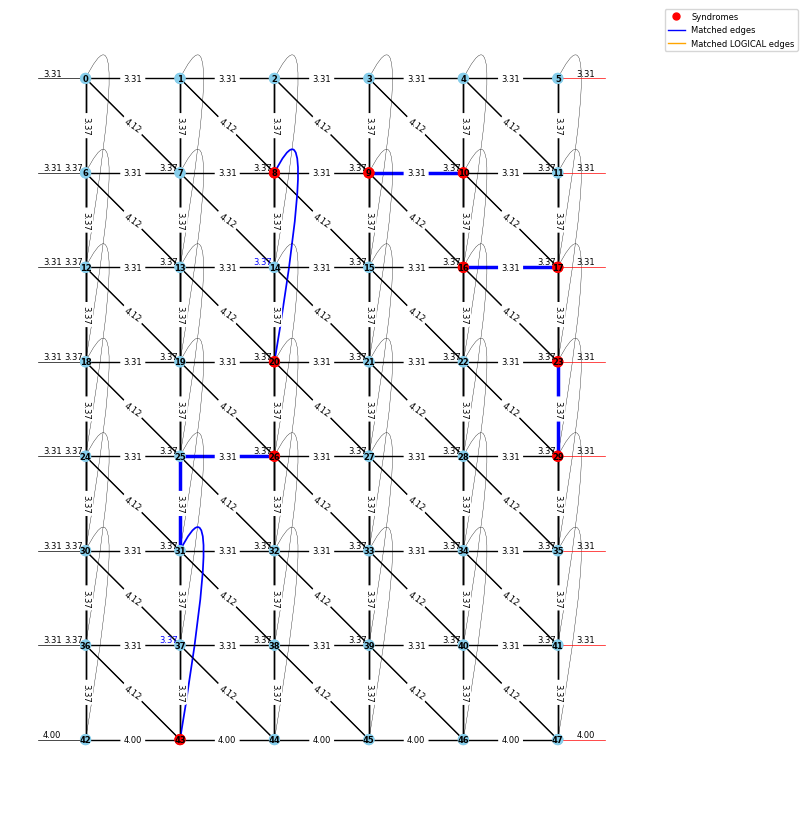

-----Second True decoding-----


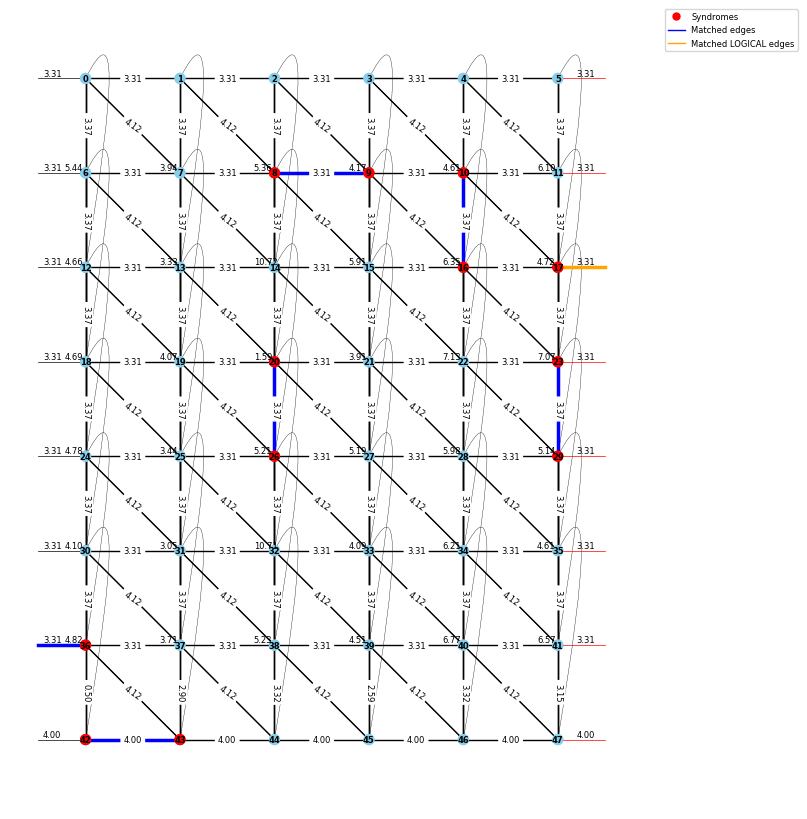

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
-----Second True decoding-----


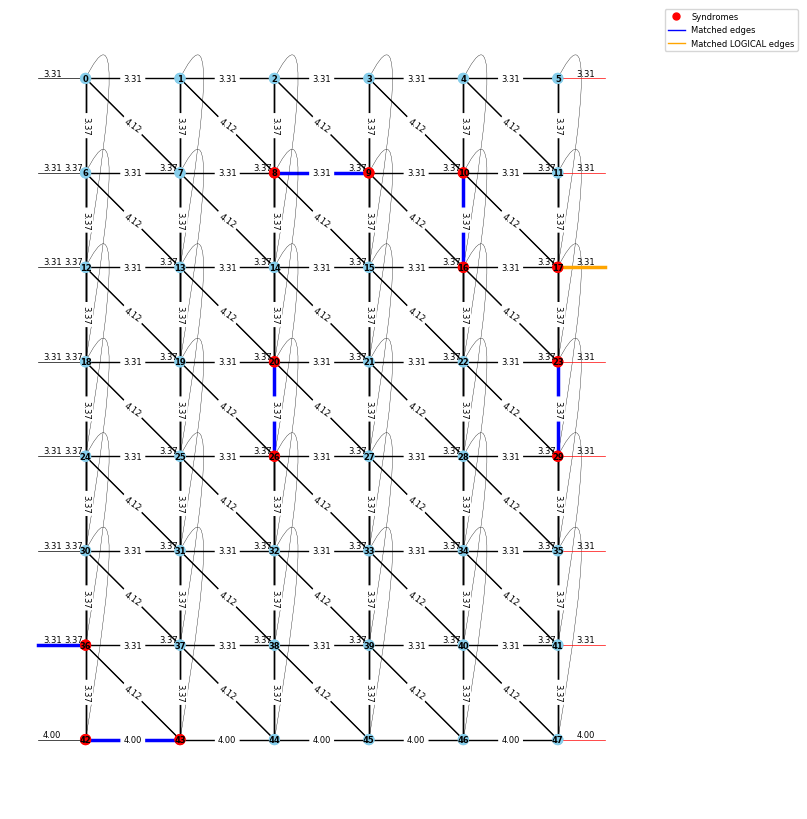

In [72]:
from soft_info import draw_matching_graph


index = 4393

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result_predecoder.decode_result
details = to_be_result.error_details[index]
print(f"----- First {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----Second {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


to_be_result = result_informed
details = to_be_result.error_details[index]
print(details.detection_syndromes)
print(f"-----Second {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)
